# Example: Detecting Parkinson using Smart Phone Sensors

This notebook evaluates FLASC to reproduce a finding by Mapper on a 
[dataset](https://data.world/deviramanan2016/smartphone-data) containing smart 
phone sensor measurements from healthy individuals and Parkinson's patients.

The data was part of a [Kaggle challenge](https://www.kaggle.com/competitions/predicting-parkinson-s-disease-progression-with-smartphone-data/data) issued
by the [Michael J. Fox foundation](https://www.michaeljfox.org/news/data-challenges).
It contains samples recorded roughly between December 2011 and March 2012 for 9 
parkinson's patients and 7 healthy controls roughly matched for age and gender.

The subjects were asked to carry a supplied Android smartphone on their person
for at least one charge-cycle per day (about 4-6 hours) during 8 weeks, as consistently
as possible. The data was recorded at most once per second in various forms:

- Audio
- Accelerometry
- Compass
- Ambient light
- Proximity
- Battery level
- GPS
  
In this notebook, we try to re-construct a Mapper network on this data presented
by Anthony Bak from (then called) [Ayasdi](https://symphonysensa.com/) at a 
[Stanford Seminar](https://youtu.be/x3Hl85OBuc0?t=3954):

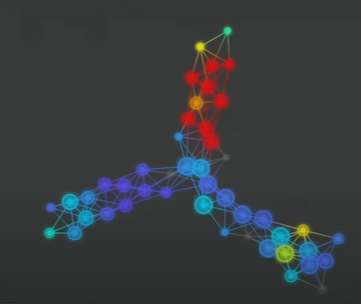

## Loading Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from flasc import FLASC
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from _plotting import *

%matplotlib inline
palette = configure_matplotlib()

Other than the file-name, I cannot find details on how the dataset used is computed
from the raw-data provided in the Kaggle competition. The first column identifies
samples from the same participant and the second column indicates whether that
participant is a control or a patient. The other columns contain unspecified
real and imaginary Fourier transform coefficients.

In [3]:
df = pd.read_csv('./data/all_FFT_3_hr_conv_60_s_128_harmonics.tsv', sep='\t')
df.head()

,Sample,Disease,Re_1,Re_2,Re_3,Re_4,Re_5,Re_6,Re_7,Re_8,...,Im_119,Im_120,Im_121,Im_122,Im_123,Im_124,Im_125,Im_126,Im_127,Im_128
0,Apple,control,2.27452,-2.98812,-3.95080,-2.98221,-3.57399,-3.50384,-3.47639,-5.30028,...,1.46128,1.80453,1.54919,1.70423,1.47270,1.44480,1.78379,1.49810,1.74807,1.69820
1,Apple,control,2.27566,-3.22163,-3.73390,-3.32565,-3.31341,-3.44289,-3.48040,-4.57056,...,-1.48798,-1.48112,-1.38925,-2.06651,-1.24703,-1.45957,-1.64805,-1.65060,-1.27808,-1.48379
2,Apple,control,2.27763,-2.75829,-2.89338,-4.92310,-3.98356,-3.26541,-3.99159,-3.39677,...,1.65722,1.58372,1.74900,1.45614,1.60677,1.63392,1.56392,1.64865,1.66224,1.61040
3,Apple,control,2.28332,-2.25339,-2.65027,-4.88183,-3.48719,-3.38162,-3.85605,-4.81275,...,1.62460,1.57034,1.31235,1.67700,1.50308,1.55768,1.53018,1.49809,1.62076,1.50912
4,Apple,control,2.29163,-2.10240,-3.99083,-3.49268,-3.49333,-3.78279,-3.46723,-3.34228,...,1.70419,1.67215,1.60885,1.47521,1.52391,1.57575,1.63493,1.61496,1.49248,1.57355


## Reproducing the Mapper network

The first goal is to reproduce the Y-shaped Mapper network. In the presentation, 
they report using a variance normalized Euclidean distance and $l_{infinity}$ 
centrality lens.

In [4]:
X = StandardScaler(with_mean=False).fit_transform(df.iloc[:, 2:])
distances = pairwise_distances(X, metric='euclidean')
eccentricity = distances.max(axis=1)
diseased = df.Disease != 'control'

### Computing a covering

Based on the presentation, their covering was *equalized* and parameterized with 
a resolution of $30$ segments, a $4.0\times$ gain. I have interpreted that gain
value to mean an overlap of $3/4$ segment.

The image below shows the resulting covering, with samples from diseased
participants in orange and control samples in blue.

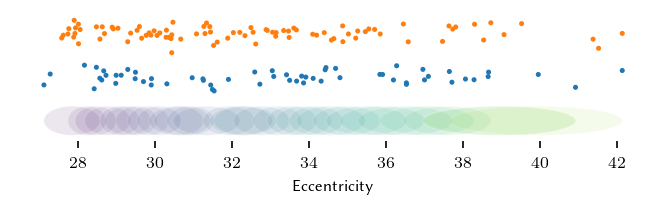

In [5]:
from gtda.mapper import OneDimensionalCover
from matplotlib.patches import Ellipse

resolution = 30
overlap = 3/4
y = diseased + np.ones(len(eccentricity)) + np.random.normal(0, 0.14, len(eccentricity))

def plot_cover(lens, starts, ends):
    sized_fig(1, aspect=0.2)
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(lens.min(), lens.max())
    plt.scatter(
        lens, 
        y, 
        2, diseased, cmap='tab10', vmax=10)
    for i, (begin, end) in enumerate(zip(starts, ends)):
        if i == 0:
            begin = lens.min()
        if i == len(starts) - 1:
            end = lens.max()
            plt.gca().add_patch(r)
        r = Ellipse(
            ((begin+end)/2, 0), 
            end-begin, 
            0.66, 
            alpha=0.1,
            facecolor=cmap(norm((begin+end)/2))
        )
        plt.gca().add_patch(r)
        
    plt.yticks([])
    plt.xlabel('Eccentricity')

cover = OneDimensionalCover(
    kind='balanced', n_intervals=resolution, overlap_frac=overlap
).fit(eccentricity)
starts, ends = cover.left_limits_, cover.right_limits_
plot_cover(eccentricity, starts, ends)

### Clustering each segment

We use HDBSCAN\* with a minimum cluster size of 5 samples for Mappers clustering 
step. The precise clustering is likely different from the first-histogram-gap 
approach used for the original Mapper network.

The condensed hierarchies are shown below, and indicate an X-shaped 
structure. To achieve the Y-shaped network, we applied a 
*cluster_selection_epsilon* of $1/0.05$, which merges the most central branches.
In our experience it is essential to visualize these kind of hierarchies when 
constructing Mapper networks. Without them it is very difficult to reason about
which clusters are detected and how they relate to each other.

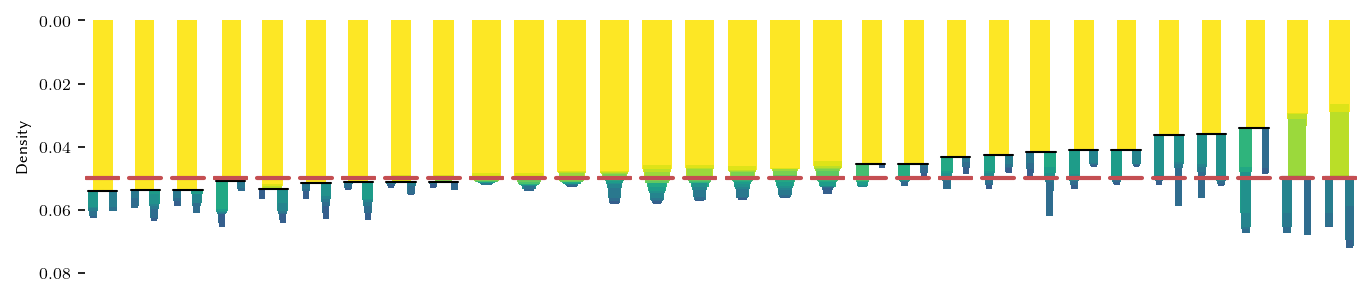

In [6]:
from hdbscan import HDBSCAN

def segment_tree(dists):
    c = HDBSCAN(
        metric='precomputed',
        min_cluster_size=5, 
        allow_single_cluster=True,
        cluster_selection_method='leaf',
        cluster_selection_epsilon=1/0.05,
    ).fit(dists)
    labels = c.labels_.copy()
    # ALl points are noise -> one big cluster
    if np.all(labels == -1):
        return np.zeros(dists.shape[0]), c
    return labels, c

pullback_sets = [
    np.where((eccentricity >= begin) & (eccentricity <= end))[0]
    for begin, end in zip(starts, ends)
] 
distances_sets = [
    distances[:, pts][pts, :]
    for pts in pullback_sets
]
label_sets, c_sets = zip(*[
    segment_tree(dist)
    for dist in distances_sets
])

sized_fig(2, aspect=0.2)
n_sets = len(pullback_sets)
for i in range(n_sets):
    plt.subplot(1, n_sets, i+1)
    c = c_sets[i]
    c.condensed_tree_.plot(colorbar=False)
    plt.ylim([0.08, 0])
    if i > 0:
        plt.axis('off')
    else:
        plt.ylabel('Density')
    plt.plot(plt.xlim(), [0.05, 0.05], 'r-', linewidth=2)
plt.show()

### Converting to Network structure

The clusters from the previous step are converted into a NetworkX graph which
we use for plotting.

In [7]:
import networkx as nx
from matplotlib import collections as mc

cnt = 0
def nodes_and_edges(pullback_sets, label_sets, starts, ends):
    global cnt
    cnt = 0
    def inc():
        global cnt
        cnt += 1
        return cnt

    node_attrs = {
        inc(): {
            'level': int(i),
            'start': float(start),
            'end': float(end),
            'diseased': float(diseased[pts[label==j]].mean()),
            'eccentricity': float(eccentricity[pts[label==j]].mean()),
            'size': int(np.sum(label == j)),
            'points': pts[label==j].astype(int).tolist()
        }
        for i, (pts, label, start, end) in enumerate(zip(
            pullback_sets, label_sets, 
            np.concatenate((starts, starts)), 
            np.concatenate((ends, ends))
        ))
        for j in np.unique(label) if j >= 0
    }
    nodes = np.arange(1, len(node_attrs), dtype=int).tolist()
    edges = []
    edge_attrs = {}

    for i in node_attrs.keys():
        for j in node_attrs.keys():
            if i == j:
                continue
            overlap = len(np.intersect1d(node_attrs[i]['points'], node_attrs[j]['points']))
            if overlap > 0:
                edges += [(i, j)]
                edge_attrs[(i,j)] = {'weight': float(overlap)}

    return nodes, node_attrs, edges, edge_attrs
    

def to_nx_graph(nodes, node_attrs, edges, edge_attrs):
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    nx.set_node_attributes(g, node_attrs)
    nx.set_edge_attributes(g, edge_attrs)
    return g


def plot_network_by(attr, **kwargs):
    color = [*nx.get_node_attributes(g, attr).values()]
    plt.gca().add_collection(
        mc.LineCollection(
            list(zip(zip(xs[source], ys[source]), zip(xs[target], ys[target]))), 
            linewidths=.5, color='k', zorder=0, alpha=0.2
        )
    )
    plt.scatter(xs, ys, size, color, cmap='turbo', **kwargs)
    plt.title(attr)
    plt.axis('off')

The resulting Mapper network does indeed consist of three branches. One more 
central branch and two branches with higher eccentricity. While the colors
are reversed, we also find one branch with more controls and two branches with
more patients. All in all, this reproduced mapper network appears quite similar
to the original one.

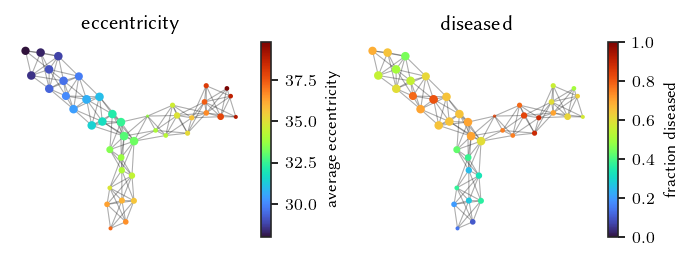

In [8]:
nodes, node_attrs, edges, edge_attrs = nodes_and_edges(
    pullback_sets, label_sets, starts, ends
)
g = to_nx_graph(nodes, node_attrs, edges, edge_attrs)

pos = nx.nx_agraph.graphviz_layout(g, prog="neato")
for n, p in pos.items():
    g.nodes[n]['pos'] = p

xs, ys = (np.asarray(x) for x in zip(*pos.values()))
source, target = [np.asarray(x) - 1 for x in zip(*edges)]
size = [*nx.get_node_attributes(g, 'size').values()]
norm = plt.Normalize(np.min(size), np.max(size))
size = [norm(s) * 10 + 0.2 for s in size]

sized_fig(1, 0.618/2)
plt.subplot(1, 2, 1)
plot_network_by('eccentricity')
plt.colorbar(label='average eccentricity')
plt.subplot(1, 2, 2)
plot_network_by('diseased', vmin=0, vmax=1)
plt.colorbar(label='fraction diseased')
plt.show()

## FLASC

Now, lets analyze this data with FLASC. Firstly, for detecting clusters, we
set *min samples=2* with *min cluster size*=5 and enable *allow single cluster*
because many points join the condensed hierarchy at the root segment, indicating
that the density maxima do not describe a large part of the dataset. Secondly, 
for detecting branches, we use *min branch size*=5 using the *core* detection method. 

In [9]:
b = FLASC(
    min_cluster_size=5,
    allow_single_cluster=True,
    label_sides_as_branches=True
).fit(X)
g2 = b.cluster_approximation_graph_

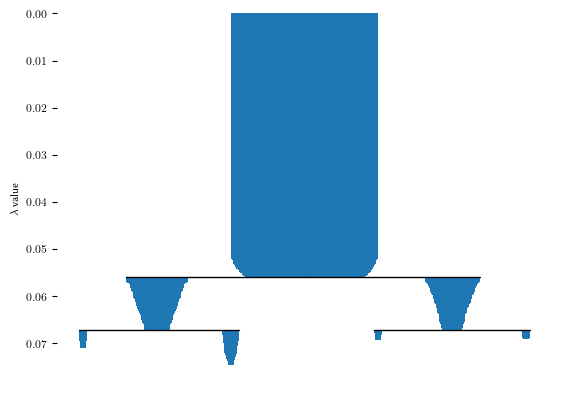

In [10]:
b.condensed_tree_.plot()
plt.show()

These settings result in one cluster and two branches, as shown in the branch
condensed hierarchy:

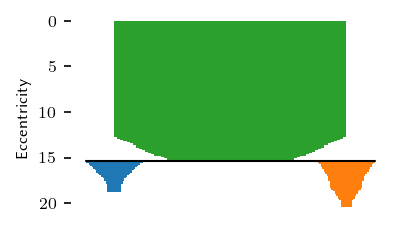

In [11]:
sized_fig(1/2)
n_clusters =  len(b.cluster_persistence_)
for i in range(n_clusters):
    plt.subplot(1, n_clusters, i+1)
    b.cluster_condensed_trees_[i].plot()
    if i ==0:
        plt.ylabel('Eccentricity')
    else:
        plt.axis('off')
plt.show()

Visualizing the *cluster approximation graph* coloured by the centrality reveals 
a hamburger-bun structure. There appear to be two distinct regions with centrality 
maxima, which would match the X-shaped mapper network we saw before.

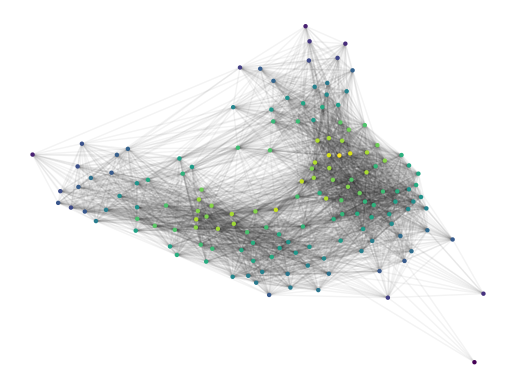

In [12]:
g2.plot(
    node_size=10, 
    node_color='cluster_centrality',
    edge_alpha=0.05,
)
plt.show()

In the figure below, the data points are coloured by their FLASC label. The
surrounding circles indicate which observations are from a diseased participant.
Visually, most controls (points without surrounding circles) lie in the blue branch.
These points form the controls-branch in the Mapper network. The green subgroup 
indicates the most-central branch in the Mapper network. The orange
branch forms the remaining Mapper branch.

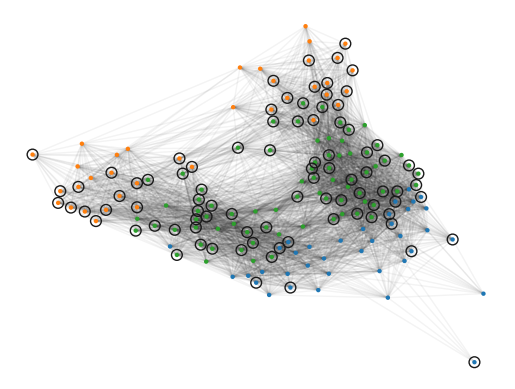

In [13]:
g2.plot(
    node_size=10, 
    edge_alpha=0.05,
)
plt.scatter(
    g2._xs[g2.point_mask & diseased],
    g2._ys[g2.point_mask & diseased],
    60,
    edgecolors='k',
    facecolors='none',
    marker='o',
)
plt.show()

### Comparing to the Mapper network

We can color the mapper network by the datapoint's FLASC labels. Specifically,
we color by the proportion of each node's points that belongs to each FLASC 
subgroup. These figures confirm the observations made previously.

In [14]:
memberships = np.zeros((X.shape[0], len(np.unique(b.labels_))))
for pts in b.cluster_points_:
    label_values = np.unique(b.labels_[pts])
    for l in label_values:
        mask = b.labels_[pts] == l
        memberships[pts[mask], l] = 1

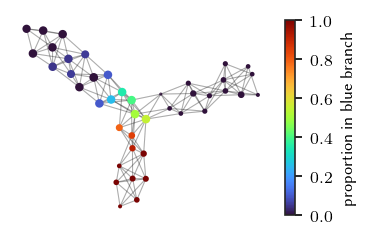

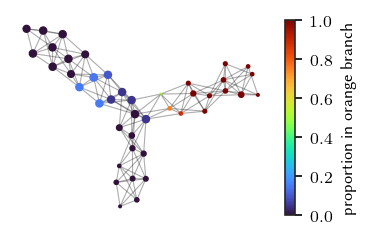

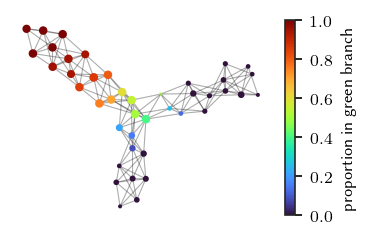

In [15]:
branches = ['blue','orange','green']
for i, branch in enumerate(branches):
    sized_fig()
    branch_score = [
        memberships[pts[label==j], i].mean()
        for pts, label in zip(
            pullback_sets, label_sets,
        )
        for j in np.unique(label) if j >= 0
    ]

    plt.gca().add_collection(
        mc.LineCollection(
            list(zip(zip(xs[source], ys[source]), zip(xs[target], ys[target]))), 
            linewidths=.5, color='k', zorder=0, alpha=0.2
        )
    )
    plt.scatter(xs, ys, size, branch_score, cmap='turbo', vmin=0)
    plt.colorbar(label=f'proportion in {branch} branch')
    plt.axis('off')
    plt.show()